In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 12 16:41:40 2019

@author: Hugo Xian
"""
import jqdata
from datetime import datetime,timedelta
#from jqfactor import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

#获取日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            return df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            return df.drop_duplicates('year-month').index 
        
tradeday_list = get_tradeday_list('2019-01-01','2019-02-01')

#输入开始日期和结束日期，返回每月第一个交易日
def get_monthday(s_date,d_date):
    df = get_price('000001.XSHG',start_date=s_date,end_date=d_date)
    dt_list = []
    for d1,d2 in zip(df.index[:-1],df.index[1:]):
        d_1 = datetime(int(str(d1)[:4]),int(str(d1)[5:7]),int(str(d1)[8:10]))
        d_2 = datetime(int(str(d2)[:4]),int(str(d2)[5:7]),int(str(d2)[8:10]))
        weekday1 = d_1.strftime("%d")
        weekday2 = d_2.strftime("%d")
        interday = (d_2 - d_1).days
        if (int(weekday1) >= int(weekday2)) or interday>30:
            dt_list.append(str(d2)[:10])
    return dt_list      

def ShiftTradingDay(date,shift):
    # 获取所有的交易日，返回一个包含所有交易日的 list,元素值为 datetime.date 类型.
    tradingday = jqdata.get_all_trade_days()
    # 得到date之后shift天那一天在列表中的行标号 返回一个数
    date = datetime(int(str(date)[:4]),int(str(date)[5:7]),int(str(date)[8:10])).date()
    #date = datetime.strftime(date,'%Y-%m-%d')
    shiftday_index = list(tradingday).index(date)+shift
    # 根据行号返回该日日期 为datetime.date类型
    return tradingday[shiftday_index] 

#进行新股、St股过滤，返回筛选后的股票
def filter_stock(stockList,date,days=21*12,skip_paused=1,limit=0):#日频策略加入开盘涨停过滤
    
    #去除上市距beginDate不足一年的股票
    def delect_stop(stocks,beginDate,n=days):
        stockList=[]
        beginDate = datetime.strptime(beginDate, "%Y-%m-%d")
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<(beginDate-timedelta(days=n)).date():
                stockList.append(stock)
        return stockList
    
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]

    #剔除当天停牌股
    if skip_paused == 1:
        paused_df = get_price(stockList,end_date=date,count=1,fields=['paused'])['paused'].T
        paused_df.columns = ['paused']
        paused_df = paused_df[paused_df['paused']==0]
        stockList = paused_df.index
    
    #新股及退市股票
    stockList=delect_stop(stockList,date)
    
    #剔除开盘涨停股票
    if limit == 1:
        #如果需要收盘涨跌停可以改字段即可
        df = get_price(stockList,end_date=date,fields=['open','high_limit','low_limit'],count=1).iloc[:,0,:]
        df['h_limit']=(df['open']==df['high_limit'])
        df['l_limit']=(df['open']==df['low_limit'])
        stockList = [df.index[i] for i in range(len(df)) if not (df.h_limit[i] or df.l_limit[i])] #过滤涨跌停股票
    return stockList

def ret_se(start_date='2018-6-1',end_date='2018-7-1',stock_pool=None,weight=0):
    pool = stock_pool
    if len(pool) != 0:
        #得到股票的历史价格数据
        df = get_price(list(pool),start_date=start_date,end_date=end_date,fields=['close']).close
        df = df.dropna(axis=1)
        #获取列表中的股票流通市值对数值
        df_mkt = get_fundamentals(query(valuation.code,valuation.circulating_market_cap).filter(valuation.code.in_(df.columns)))
        df_mkt.index = df_mkt['code'].values
        fact_se =pd.Series(df_mkt['circulating_market_cap'].values,index = df_mkt['code'].values)
        fact_se = np.log(fact_se)
    else:
        df = get_price('000001.XSHG',start_date=start_date,end_date=end_date,fields=['close'])
        df['v'] = [1]*len(df)
        del df['close']
    #相当于昨天的百分比变化
    pct = df.pct_change()+1
    pct.iloc[0,:] = 1
    if weight == 0:
        #等权重平均收益结果
        se = pct.cumsum(axis=1).iloc[:,-1]/pct.shape[1]
        return se
    else:
        #按权重的方式计算
        se = (pct*fact_se).cumsum(axis=1).iloc[:,-1]/sum(fact_se)
        return se

#获取所有分组pct
def get_all_pct(pool_dict,trade_list,groups=5):
    num = 1
    for s,e in zip(trade_list[:-1],trade_list[1:]):
        stock_list = pool_dict[s]
        stock_num = len(stock_list)//groups
        if num == 0:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df1 = pd.concat(pct_se_list,axis=1)
            pct_df1.columns = range(groups)
            pct_df = pd.concat([pct_df,pct_df1],axis=0)
        else:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df = pd.concat(pct_se_list,axis=1)    
            pct_df.columns = range(groups)
            num = 0
    return pct_df

##定义动量因子计算
#动量因子计算 返回dataFrame,index:[1M,3M,6M,12M,24M],columns:stock
def factor_M(pool,date):
    df = pd.DataFrame(index=['1M','3M','6M','12M','24M'])
    dt = datetime.strptime(date,'%Y-%m-%d')
    for stock in pool[:]:      
        price_1e = get_price(stock,end_date=date,count=1,fields=['close'])['close']
        price_1 = []
        for i in [1,3,6,12,24]:
            start_dt = dt - timedelta(days=30*i)
            if start_dt < datetime.strptime('2006-01-01','%Y-%m-%d'):
                start_dt = datetime.strptime('2006-01-01','%Y-%m-%d')
            end_dt = start_dt + timedelta(days=10)
            price = get_price(stock,start_date=start_dt,end_date=end_dt,fields=['close']).iloc[0,0]
            price_1.append(price)
        one_M = price_1e[0] / price_1[0]-1
        three_M = price_1e[0] / price_1[1] - 1
        six_M = price_1e[0] / price_1[2] - 1 
        twlve_M = price_1e[0] / price_1[3] - 1
        twf_M = price_1e[0] / price_1[4] - 1
        df[stock] = [one_M,three_M,six_M,twlve_M,twf_M]
    return df
# a = factor_M(['600000.XSHG','000002.XSHE'],'2006-01-04')



In [ ]:
##设置参数初始化
date_start = '2006-01-01'
date_end = '2019-05-31' #'2019-05-31'
#设置股票池(成分股)
index = '000002.XSHG' #全A股
#获取统计期内交易日列表、用于计算因子数据
date_list = get_tradeday_list(start=date_start,end=date_end,count=None)
#循环日期列表，进行因子值记录，按字典的方式存储
#进行因子值计算
factor_dict = {}
for end_date in date_list[:]:
    try:     
        end_date = str(end_date)[0:10]
        print("正在计算 {} 因子数据".format(end_date))
        stocks_list = get_index_stocks(index,date=end_date)#获取指定日期成分股列表
        stocks_list = filter_stock(stocks_list,end_date,days=365,limit=1)#进行股票筛选
        b=factor_M(pool=stocks_list,date=end_date)
        factor_dict[end_date] = b#计算因子值进行存储
    except:
        continue

import os 
path = os.getcwd()
import pickle
pkl_file = open(path+'/GuangdaFuXian2.pkl','wb')
pickle.dump(factor_dict,pkl_file)
pkl_file.close()

计算数据耗时：61.52759647369385
(1340, 6)
===================因子：1M Ic统计信息如下===============
        IC均值     IC标准差    IC最小值     IC最大值   负IC占比        IC        IR
1M -0.050646  0.147555 -0.47211  0.326146  0.6352 -8.052748 -0.343236
===================因子：3M Ic统计信息如下===============
        IC均值     IC标准差     IC最小值     IC最大值   负IC占比        IC        IR
1M -0.050646  0.147555 -0.472110  0.326146  0.6352 -8.052748 -0.343236
3M -0.056100  0.150250 -0.473596  0.341647  0.6604 -8.919922 -0.373379
===================因子：6M Ic统计信息如下===============
        IC均值     IC标准差     IC最小值     IC最大值   负IC占比        IC        IR
1M -0.050646  0.147555 -0.472110  0.326146  0.6352 -8.052748 -0.343236
3M -0.056100  0.150250 -0.473596  0.341647  0.6604 -8.919922 -0.373379
6M -0.047584  0.151818 -0.566688  0.341647  0.6101 -7.565868 -0.313428
===================因子：12M Ic统计信息如下===============
         IC均值     IC标准差     IC最小值    ...      负IC占比        IC        IR
1M  -0.050646  0.147555 -0.472110    ...     0.6352 -8.0527

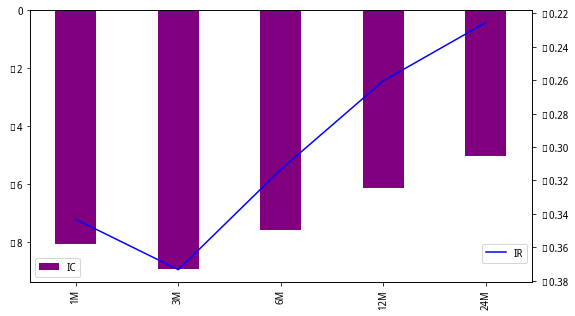

In [2]:
import os 
path = os.getcwd()
import pickle
file1 = open(path + "/GuangdaFuXian1.pkl","rb")
factor_dict1 = pickle.load(file1)
file1.close()
file2 = open(path + "/GuangdaFuXian2.pkl","rb")
factor_dict2 = pickle.load(file2)
file2.close()
factor_dict = factor_dict1.copy()
factor_dict.update(factor_dict2)


#设置是否中性化
neu = 0 #1为进行中性化；0为不进行中性化
how = ['sw_l1', 'market_cap']
#获取调仓日历、交易列表
s_date = '2006-01-01'
d_date = '2019-05-31'
trade_list = get_monthday(s_date,d_date)#获取每月第一个交易日列表
trade_list[-5:]

#数据清洗、包括去极值、标准化、中性化等，并加入y值
def winsorize(df, nsigma=3):
    #传入df 行：股票   列：因子类型
    median = df.median(axis=1)
    mad = 1.483 * (df.sub(median, axis=0)).abs().median(axis=1)
    up = df.apply(lambda k: k > median + mad * nsigma)
    down = df.apply(lambda k: k < median - mad * nsigma)
    df[up] = df[up].rank(axis=1, pct=True).multiply(mad * 0.5, axis=0).add(median + mad * nsigma, axis=0)
    df[down] = df[down].rank(axis=1, pct=True).multiply(mad * 0.5, axis=0).add(median - mad * (0.5 + nsigma), axis=0)
    return df

t1 = time.time()
factor_y_dict = {}
for date_1,date_2 in zip(trade_list[:-1],trade_list[1:]):
    d1 = ShiftTradingDay(date_1,1)#往后推一天
    d2 = ShiftTradingDay(date_2,1)
    factor_df = factor_dict[str(date_1)[:10]].T
    pool = list(factor_df.index)
    
    #计算涨跌幅
    df_1 = get_price(index, end_date=d1,fields=['open'],count=1)['open']
    df_2 = get_price(index, end_date=d2,fields=['open'],count=1)['open']
    index_pct = df_2.values[0]/df_1.values[0]-1
    
    #计算各股票涨跌幅
    df_1 = get_price(pool, end_date=d1,fields=['open'],count=1)['open']
    df_2 = get_price(pool, end_date=d2,fields=['open'],count=1)['open']
    df_3 = pd.concat([df_1,df_2],axis=0).T
    stock_pct = df_3.iloc[:,1]/df_3.iloc[:,0]-1
    
    #对数据进行处理、标准化、去极值、中性化
    #factor_df = winsorize(factor_df, scale=3, inclusive=True, inf2nan=True, axis=0) #中位数去极值处理
    #factor_df = standardlize(factor_df, inf2nan=True, axis=0) #对每列做标准化处理
    #if neu == 1:
    #    factor_df = neutralize(factor_df, how=['sw_l1','market_cap'], date=date_1, axis=0,fillna='sw_l1')#中性化

    #factor_df['pct_alpha'] =  stock_pct-index_pct
    factor_df['pct_'] =  stock_pct
    factor_y_dict[date_1] = factor_df
t2 = time.time()
print('计算数据耗时：{0}'.format(t2-t1))
print(factor_y_dict[date_1].shape)
"""
import pickle
with open("E:\Project\研报复现\GuangdaDongLiang",'wb') as file:  ##保存数据
    pickle.dump(factor_dict, file)
with open("E:\Project\研报复现\GuangdaDongLiang",'rb') as file: ##读取
    factor_dict = pickle.load(file)
"""
##因子分析
#统计记录IC值
ic_df = pd.DataFrame()
for d in trade_list[:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_y_dict[d].corr()).iloc[:6,-1]
ic_df

#设置要统计的因子名称
factor = '1M'
factor_list = ['1M','3M','6M','12M','24M']
tab_ic = pd.DataFrame()
for factor in factor_list:
    print("===================因子：{} Ic统计信息如下===============".format(factor))
    ic_ = ic_df.T
    #ic_temp = ic_[(ic_.index>(str(year)+'-01-01')) & (ic_.index<(str(year+1)+'-01-01'))]
    tab_ic[factor] = [ic_[factor].mean(),ic_[factor].std(),ic_[factor].min(),ic_[factor].max(),round(sum(ic_[factor]<0)/len(ic_),4),\
           ic_[factor].sum(),ic_[factor].mean()/ic_[factor].std()]
    tab_ic.index = ['IC均值','IC标准差','IC最小值','IC最大值','负IC占比','IC','IR']
    print(tab_ic.T)
tab_ic_temp = tab_ic.loc[['IC','IR'],:].T
fig1 = plt.figure(figsize=(9,5))
ax1 = tab_ic_temp.IC.plot.bar(color='purple',width=0.4)
plt.legend()
ax2 = ax1.twinx()
tab_ic_temp.IR.plot(color='blue',secondary_y='IC_IR')
plt.legend(bbox_to_anchor=(1.0,0.16))
plt.show()




==============因子： 1M 分组收益如下===============
             总收益    年化收益    夏普率   最大回撤   每日收益%
group0   -24.94%   -2.1%  -0.13  0.83%  0.0155
group1   167.97%   7.56%   0.15  0.72%  0.0508
group2   535.17%  14.64%   0.37  0.69%  0.0763
group3   642.63%  15.98%   0.41  0.69%  0.0807
group4  1219.95%  21.01%   0.57  0.71%  0.0979
group5  1832.38%  24.47%   0.67  0.69%  0.1094
group6   1820.9%  24.42%   0.67  0.69%  0.1092
group7  1890.24%  24.74%   0.67  0.68%  0.1104
group8   1372.9%   22.0%   0.59  0.69%  0.1018
group9  1326.08%  21.71%   0.57  0.67%  0.1018


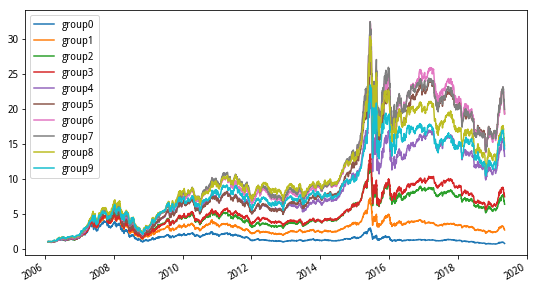

==============因子： 3M 分组收益如下===============
             总收益    年化收益    夏普率   最大回撤   每日收益%
group0   -19.51%  -1.59%  -0.12  0.83%  0.0174
group1   242.35%   9.52%   0.21  0.72%  0.0585
group2   383.77%  12.36%    0.3   0.7%  0.0682
group3   779.82%  17.44%   0.46   0.7%  0.0861
group4   879.37%  18.37%   0.48  0.68%  0.0892
group5  1022.97%  19.58%   0.52  0.72%  0.0933
group6  1783.75%  24.24%   0.67  0.69%  0.1083
group7  1364.12%  21.94%   0.59  0.68%  0.1014
group8  1683.04%  23.73%   0.64   0.7%  0.1075
group9  2573.42%  27.49%   0.74  0.68%  0.1202


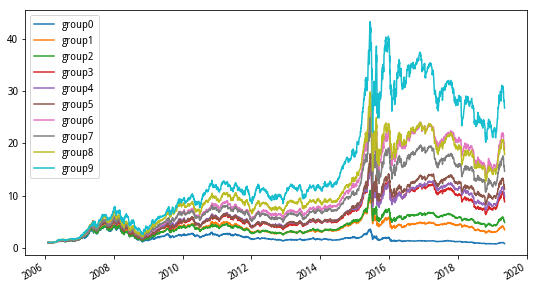

==============因子： 6M 分组收益如下===============
             总收益    年化收益    夏普率   最大回撤   每日收益%
group0    13.07%   0.91%  -0.05  0.74%  0.0271
group1    169.8%   7.61%   0.15  0.73%  0.0516
group2   449.17%  13.42%   0.33  0.72%  0.0723
group3   645.56%  16.01%   0.41  0.69%  0.0813
group4  1358.44%  21.91%   0.59  0.69%   0.101
group5  1175.82%  20.71%   0.56  0.66%   0.097
group6  1495.78%  22.72%   0.62  0.69%  0.1037
group7  1725.15%  23.95%   0.66  0.71%  0.1076
group8  1395.34%  22.13%   0.59  0.69%  0.1022
group9  1536.54%  22.95%   0.61  0.69%  0.1054


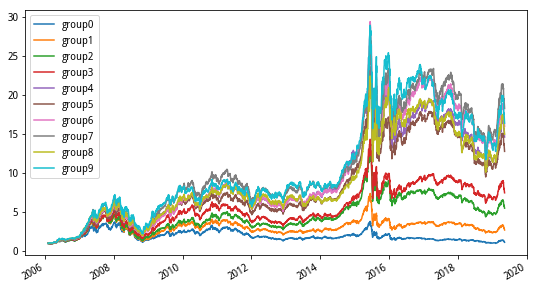

==============因子： 12M 分组收益如下===============
             总收益    年化收益   夏普率   最大回撤   每日收益%
group0    48.91%   2.99%  0.01  0.73%  0.0345
group1    290.4%  10.59%  0.25  0.75%  0.0622
group2   391.93%   12.5%   0.3  0.74%  0.0693
group3   675.87%  16.35%  0.42  0.72%  0.0823
group4  1116.97%  20.29%  0.54  0.69%  0.0958
group5   1217.0%  20.99%  0.56  0.66%  0.0979
group6  1441.72%  22.41%   0.6  0.67%  0.1028
group7  1406.72%   22.2%   0.6  0.68%  0.1024
group8  1374.84%  22.01%  0.59  0.67%  0.1014
group9  1376.73%  22.02%  0.58  0.67%  0.1024


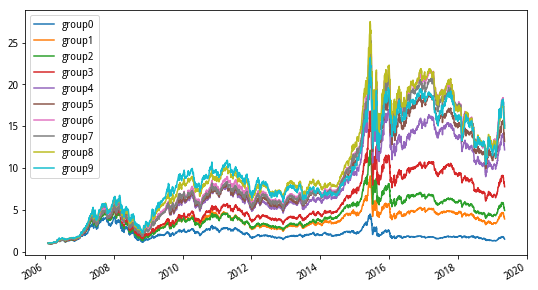

==============因子： 24M 分组收益如下===============
             总收益    年化收益   夏普率   最大回撤   每日收益%
group0    60.97%   3.58%  0.03  0.77%  0.0365
group1   296.17%  10.71%  0.25  0.74%   0.063
group2   446.75%  13.38%  0.33  0.71%   0.072
group3   662.97%  16.21%  0.42  0.72%  0.0821
group4    873.9%  18.32%  0.48  0.72%  0.0896
group5  1228.48%  21.07%  0.56  0.69%  0.0986
group6  1273.13%  21.37%  0.57  0.67%  0.0997
group7  1152.36%  20.54%  0.55  0.65%  0.0968
group8  1875.42%  24.67%  0.68  0.65%  0.1098
group9  1598.69%  23.29%  0.63  0.64%  0.1057


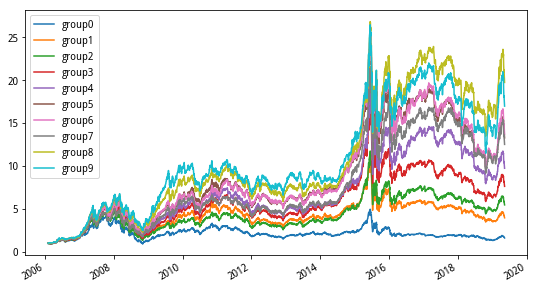

In [29]:
#分组回测
#进行因子值回测分组收益统计 计算多空夏普率、换手率、 Mono_Score=(10组年化收益-1组年化收益)/(8组年化收益-3组年化收益) 
#分组个数
group=10#分组组数
group_pct_all = {}

factor_list = ['1M','3M','6M','12M','24M']#list(ic_df.index[:-1])#获取所有统计因子值
def get_risk_index(se):#输入每日收益变化，从零算起
    return_se = se.cumprod()-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(250/len(return_se))-1)
    sharpe = (total_an_returns-0.025)/(np.std(se)*np.sqrt(250))
    returns_mean = round(se.mean()-1,6)*100
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low = min(ret[i:])
        high = max(ret[0:i])
        if high>low:
            #print(high.low)
            maxdown_list.append((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    #print('策略运行时间：{} 至 {}'.format(str(return_se.index[0])[:10],str(return_se.index[-1])[:10]))
    total_returns = str(round(total_returns*100,2))+'%'
    total_an_returns = str(round(total_an_returns*100,2))+'%'
    sharpe = str(round(sharpe,2))
    max_drawdown = str(round(max_drawdown,2))+'%'
    '''
    print('总收益：%s'%round(total_returns*100,2)+'%')
    print('年化收益：%s'%round(total_an_returns*100,2)+'%')
    print('夏普比率：%s'%round(sharpe,2))
    print('最大回撤：%s'%round(max_drawdown*100,2)+'%')
    '''
    return total_returns,total_an_returns,sharpe,max_drawdown,returns_mean

for factor in factor_list:
    factor_df = pd.DataFrame()
    for d in trade_list[:]:
        d = str(d)[:10]
        factor_df[d] = factor_dict[d].T.loc[:,factor]
    factor_df = factor_df.T
    #统计分组收益
    #分组回测分析
    #输入：index为日期，column是股票名，values是因子值得factor_df
    #输出：股票池分组收益
    pool_dict = {}
    for i in range(len(factor_df.index)):
        temp_se = factor_df.iloc[i,:].sort_values(ascending=False)#从大到小
        #pool = temp_se[temp_se>0].index #去掉小于0的值
        temp_se = temp_se.dropna()
        pool = temp_se.index
        num = int(len(pool)/group)
        #print('第%s期每组%s只股票'%(i,num))
        pool_dict[factor_df.index[i]] = pool
    backtest_list = factor_df.index
    group_pct = get_all_pct(pool_dict,backtest_list,groups=group)
    group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
    group_pct_all[factor] = group_pct
    #进行分组收益统计
    risk_index = group_pct.apply(get_risk_index,axis=0)    
    risk_tab = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤','每日收益%'])
    for i in range(group):
        risk_tab['group'+str(i)] = list(risk_index.values[i])
    print('==============因子： {} 分组收益如下==============='.format(factor))
    print(risk_tab.T)
    group_pct.cumprod().plot(figsize=(9,5))
    plt.show()



In [81]:
# path = os.getcwd()
# file = open(path + '/GuangdaGroup_pct_all.pkl','wb')
# pickle.dump(group_pct_all,file)
# file.close()

In [78]:
mono_score = pd.DataFrame(columns=factor_list)
for key in group_pct_all.keys():   
    risk_index_factor = group_pct_all[key].apply(get_risk_index,axis=0)    
    risk_tab = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤','每日收益%'])
    for i in range(group):
        risk_tab['group'+str(i)] = list(risk_index_factor.values[i])
    risk_tab = risk_tab.T
    mono_score.loc[0,key] = (float(risk_tab.loc['group9','年化收益'].strip('%')) - float(risk_tab.loc['group0','年化收益'].strip('%')))/(float(risk_tab.loc['group7','年化收益'].strip('%')) - float(risk_tab.loc['group2','年化收益'].strip('%')))


2.357425742574258
3.035490605427974
2.0930674264007596
1.9618556701030931
2.7527932960893864


In [2]:
import os 
path = os.getcwd()
import pickle
file1 = open(path + "/GuangdaFuXian1.pkl","rb")
factor_dict1 = pickle.load(file1)
file1.close()
file2 = open(path + "/GuangdaFuXian2.pkl","rb")
factor_dict2 = pickle.load(file2)
file2.close()
factor_dict = factor_dict1.copy()
factor_dict.update(factor_dict2)

In [82]:
group = 1
group_pct = pd.DataFrame()
for factor in factor_list:   
    factor_df = pd.DataFrame()
    for d in trade_list[:]:
        d = str(d)[:10]
        factor_df[d] = factor_dict[d].T.loc[:,factor]
    factor_df = factor_df.T
    #统计分组收益
    #分组回测分析
    #输入：index为日期，column是股票名，values是因子值得factor_df
    #输出：股票池分组收益
    pool_dict = {}
    for i in range(len(factor_df.index)):
        temp_se = factor_df.iloc[i,:].sort_values(ascending=False)#从大到小
        #pool = temp_se[temp_se>0].index #去掉小于0的值
        temp_se = temp_se.dropna()
        pool = temp_se.index
        num = int(len(pool)/group)
        #print('第%s期每组%s只股票'%(i,num))
        pool_dict[factor_df.index[i]] = pool
    backtest_list = factor_df.index
    group_pct_tmp = get_all_pct(pool_dict,backtest_list,groups=group)
    group_pct = pd.concat([group_pct, group_pct_tmp],axis=1)
    #进行分组收益统计
    risk_index = group_pct_tmp.apply(get_risk_index,axis=0)    
    risk_tab = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤','每日收益%'])
#     for i in range(group):
#         risk_tab['All'] = list(risk_index.values[0])
#     print('==============因子： {} 收益如下==============='.format(factor))
#     print(risk_tab.T)
#     group_pct.cumprod().plot(figsize=(9,5))
#     plt.show()
group_pct.columns = factor_list

In [87]:
# path = os.getcwd()
# file = open(path + '/GuangdaGroup_pct.pkl','wb')
# pickle.dump(group_pct,file)
# file.close()

In [ ]:
path = os.getcwd()
file = open(path + '/GuangdaGroup_pct.pkl','rb')
group_pct = pickle.load(file)
file.close()

In [121]:
factor_score = pd.DataFrame()
for column in group_pct.columns:
    list_tmp = list(pd.DataFrame(group_pct[column],columns=[column]).apply(get_risk_index,axis=0).values[0])
    risk_index_tmp = pd.DataFrame(list_tmp,index=['总收益','年化收益','夏普率','最大回撤','每日收益%'],columns=[column])
    factor_score[column] = pd.concat([mono_score[column], risk_index_tmp.T.loc[column,['夏普率','最大回撤']]],axis=0) 
factor_score.index = ['Mono_Score','夏普率','最大回撤']

In [124]:
factor_score

,1M,3M,6M,12M,24M
Mono_Score,2.35743,3.03549,2.09307,1.96186,2.75279
夏普率,0.46,0.46,0.46,0.46,0.46
最大回撤,0.7%,0.7%,0.7%,0.7%,0.7%


<BarContainer object of 5 artists>

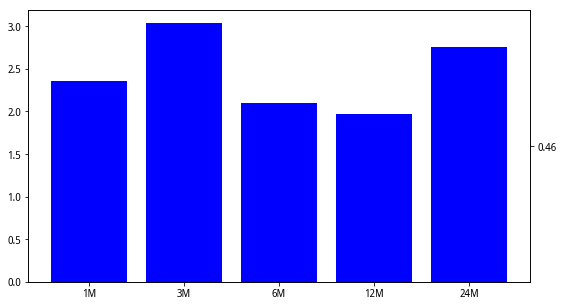

In [133]:
fig1 = plt.figure(figsize=(9,5))
ax1 = fig1.add_subplot(111)
ax1.bar(factor_score.columns,factor_score.loc['Mono_Score',:],color='blue')

ax2 = ax1.twinx()
ax2.bar(factor_score.columns,factor_score.loc['夏普率',:],color='red')


In [114]:
risk_index_tmp

,1M
总收益,771.69%
年化收益,17.36%
夏普率,0.46
最大回撤,0.7%
每日收益%,0.0853


In [99]:
mono_score1 = mono_score